#### Lab 3 - Image captioning task

Datset used - https://www.kaggle.com/datasets/adityajn105/flickr8k (Flickr8k)




In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 98% 1.02G/1.04G [00:07<00:00, 107MB/s] 
100% 1.04G/1.04G [00:07<00:00, 152MB/s]


In [ ]:
!mkdir dataset && cd dataset && unzip ../flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed7be3.jpg  
  inflating: Images/2852982055_8112d0

In [21]:
import pandas
import numpy
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from build import *
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


In [14]:
# Define the directory paths
image_dir = r"/content/dataset/Images"
text_dir = r"/content/dataset"
max_image_count = 10000000

- Here we create a dictionary of the format {image_name:Image_discription} and then save it to a pickle file.

Lets open a random image and see it's discription

In [38]:
import re
import string
from pickle import dump

# Read the raw captions
with open(f"{text_dir}/captions.txt", "r") as f:
    raw_caption = f.read()

# Function to create a caption dictionary from raw text
def caption_dictionary(raw_text):
    caption_dict = {}
    lines = raw_text.strip().split('\n')
    for line in lines:
        # Split the line into the image id and the caption
        print(line)
        image_id, caption = line.split(',', 1)
        # Remove the last 2 characters from the image id to get the filename
        image_id = image_id[:-4]
        if image_id not in caption_dict:
            caption_dict[image_id] = []
        caption_dict[image_id].append(caption)
    return caption_dict

# Function to clean the captions
def caption_cleaning(captions):
    table = str.maketrans('', '', string.punctuation)
    for key, captions_list in captions.items():
        cleaned_captions = []
        for caption in captions_list:
            caption = caption.lower()
            caption = caption.translate(table)
            caption = re.sub(r'\s+', ' ', caption)
            cleaned_captions.append(caption)
        captions[key] = cleaned_captions
    return captions

# Create the caption dictionary
caption_dict = caption_dictionary(raw_caption)
# Clean the captions
caption_dict = caption_cleaning(caption_dict)

# Save the caption_dict for future use
with open("captions.pkl", "wb") as f:
    dump(caption_dict, f)

print("Captions processed and saved.")


Streaming output truncated to the last 5000 lines.
378453580_21d688748e.jpg,A dog with a stick in his mouth jumps over a fallen tree in the forest .
378453580_21d688748e.jpg,Dog carries stick and jumps over a log .
378453580_21d688748e.jpg,The dog carries a stick and jumps over a log in the woods .
378453580_21d688748e.jpg,The dog jumps over the log with a stick in its mouth .
379006645_b9a2886b51.jpg,A black and brown dog is running between two cement barriers with snow .
379006645_b9a2886b51.jpg,a dog runs down the cold aisle .
379006645_b9a2886b51.jpg,Black and tan small dog walking with perked ears .
379006645_b9a2886b51.jpg,"The black and brown dog walks toward the camera , in an enclosed , snowy area ."
379006645_b9a2886b51.jpg,The brown and black dog is running through a snowy street .
380034515_4fbdfa6b26.jpg,A furry dog is running through a doorway leading to plants .
380034515_4fbdfa6b26.jpg,"A furry , tan dog is outside on a patio ."
380034515_4fbdfa6b26.jpg,"A short , furry

In [12]:
# raw_caption = None
# with open("./dataset/captions.txt", "r") as f:
    #raw_caption = f.read()

#caption_dict = caption_dictionary(raw_caption)
#caption_dict = caption_cleaning(caption_dict)

#Save the caption_dict for future use
#with open("captions.pkl", "wb") as f:
#    dump(caption_dict, f)

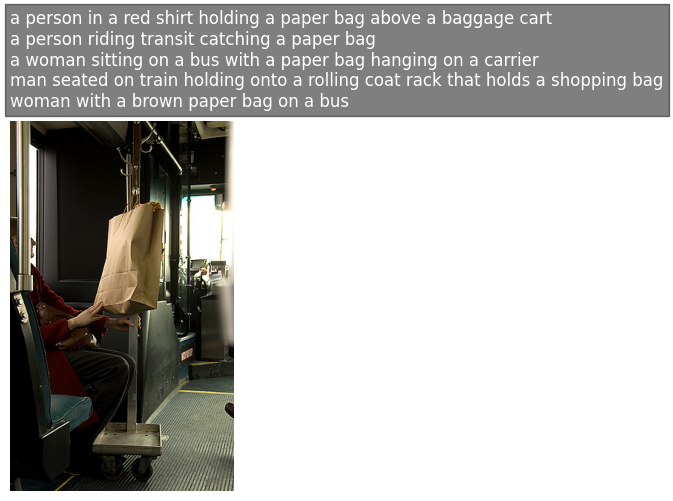

In [40]:
from PIL import Image
import random
import os

random_index = random.randint(0, len(caption_dict) - 1)
random_image_id = list(caption_dict.keys())[random_index]

random_captions = caption_dict[random_image_id]
image_path = os.path.join(image_dir,random_image_id+".jpg")
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axis
description = "\n".join(random_captions)  # Join multiple captions into a single string with line breaks
plt.text(0, -20, description, color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

plt.show()



- We need to extract the CNN features for all the images and store them in a pickle file so that can feed it to our final model.
- We store it in a dictionary form of the format { image_name : Feature_array }

In [42]:
import tensorflow.keras as keras

def feature_extractions(directory):
    """
    Input: directory of images
    Return: A dictionary of features extracted by VGG-16, size 4096.
    """

    model = tf.keras.applications.vgg16.VGG16()
    model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[-2].output) #Remove the final layer
    image_count_max = max_image_count
    features = {}
    for f in tqdm(os.listdir(directory)):
        if image_count_max < 0:
            break
        image_count_max -= 1

        filename = directory + "/" + f
        identifier = f.split('.')[0]

        image = keras.preprocessing.image.load_img(filename, target_size=(224,224))
        arr = keras.preprocessing.image.img_to_array(image, dtype=np.float32)
        arr = arr.reshape((1, arr.shape[0], arr.shape[1], arr.shape[2]))
        arr = keras.applications.vgg16.preprocess_input(arr)
        feature = model.predict(arr, verbose=0)
        features[identifier] = feature

        print("feature extraction: {}".format(f))
    return(features)

features = feature_extractions(image_dir)
with open("features.pkl", "wb") as f:
    dump(features, f)

  0%|          | 1/8091 [00:00<37:30,  3.59it/s]

feature extraction: 3174156702_95a1cda2d9.jpg
feature extraction: 3293753378_7a8ddb98b2.jpg


  0%|          | 4/8091 [00:00<18:23,  7.33it/s]

feature extraction: 3567061016_62768dcce1.jpg
feature extraction: 3356901257_83811a19eb.jpg


  0%|          | 6/8091 [00:00<16:11,  8.32it/s]

feature extraction: 2733659177_d74a00995b.jpg
feature extraction: 3367053761_8ec5834bf3.jpg
feature extraction: 2549968784_39bfbe44f9.jpg


  0%|          | 9/8091 [00:01<14:58,  8.99it/s]

feature extraction: 2261169495_98254e2e66.jpg
feature extraction: 3451523035_b61d79f6a8.jpg


  0%|          | 10/8091 [00:01<14:46,  9.11it/s]

feature extraction: 3485599424_94de8ede51.jpg
feature extraction: 3327487011_1372c425fb.jpg


  0%|          | 13/8091 [00:01<14:19,  9.40it/s]

feature extraction: 3600403707_527aa0596e.jpg
feature extraction: 3597210806_95b07bb968.jpg


  0%|          | 15/8091 [00:01<14:53,  9.04it/s]

feature extraction: 294353408_d459bdaa68.jpg
feature extraction: 384465370_9918873f9a.jpg
feature extraction: 3706653103_e777a825e4.jpg


  0%|          | 19/8091 [00:02<11:51, 11.34it/s]

feature extraction: 2509824208_247aca3ea3.jpg
feature extraction: 1957371533_62bc720bac.jpg
feature extraction: 3285993030_87b0f1d202.jpg


  0%|          | 21/8091 [00:02<11:30, 11.69it/s]

feature extraction: 2075321027_c8fcbaf581.jpg
feature extraction: 460478198_83039f2593.jpg
feature extraction: 3335501468_628655d608.jpg


  0%|          | 25/8091 [00:02<11:01, 12.19it/s]

feature extraction: 3643074723_94d42b7a0c.jpg
feature extraction: 2713554148_64cd465e71.jpg
feature extraction: 2419591925_1038c6c570.jpg


  0%|          | 27/8091 [00:02<10:56, 12.29it/s]

feature extraction: 72964268_d532bb8ec7.jpg
feature extraction: 3042484940_0975a5e486.jpg
feature extraction: 3667822570_d39850e217.jpg


  0%|          | 31/8091 [00:03<10:27, 12.85it/s]

feature extraction: 2683963310_20dcd5e566.jpg
feature extraction: 2071309418_1d7580b0f0.jpg
feature extraction: 3691800116_6a7b315e46.jpg


  0%|          | 33/8091 [00:03<10:27, 12.85it/s]

feature extraction: 3247052319_da8aba1983.jpg
feature extraction: 3108544687_c7115823f5.jpg
feature extraction: 2194286203_5dc620006a.jpg


  0%|          | 37/8091 [00:03<10:18, 13.02it/s]

feature extraction: 3105929913_94a6882e25.jpg
feature extraction: 2218907190_5f43bf5e4d.jpg
feature extraction: 2813033949_e19fa08805.jpg


  0%|          | 39/8091 [00:03<10:24, 12.89it/s]

feature extraction: 661749711_6f408dad62.jpg
feature extraction: 3420284416_a90af1fb7a.jpg
feature extraction: 1936215201_d03a75cbba.jpg


  1%|          | 43/8091 [00:03<11:29, 11.67it/s]

feature extraction: 3206058778_7053ee6b52.jpg
feature extraction: 3319020762_d429d56a69.jpg
feature extraction: 3004359992_f6b3617706.jpg


  1%|          | 45/8091 [00:04<11:05, 12.10it/s]

feature extraction: 1473618073_7db56a5237.jpg
feature extraction: 2354456107_bf5c766a05.jpg
feature extraction: 462198798_89e2df0358.jpg


  1%|          | 49/8091 [00:04<10:36, 12.63it/s]

feature extraction: 2480668859_6f9b46be6a.jpg
feature extraction: 3006217970_90b42e6b27.jpg
feature extraction: 241346402_5c070a0c6d.jpg


  1%|          | 51/8091 [00:04<10:43, 12.49it/s]

feature extraction: 3100251515_c68027cc22.jpg
feature extraction: 1449370354_380c4123c9.jpg
feature extraction: 3587941206_36769c3f1d.jpg


  1%|          | 55/8091 [00:04<10:38, 12.59it/s]

feature extraction: 2882893687_1d10d68f2b.jpg
feature extraction: 3590294974_4ef98f013e.jpg
feature extraction: 3372340429_91c4f4af30.jpg


  1%|          | 57/8091 [00:05<10:29, 12.77it/s]

feature extraction: 2939197393_93dc64c4bb.jpg
feature extraction: 404702274_fa8b3fe378.jpg
feature extraction: 3110649716_c17e14670e.jpg


  1%|          | 61/8091 [00:05<10:10, 13.16it/s]

feature extraction: 3502459991_fdec2da131.jpg
feature extraction: 2735290454_1bd8bc5eac.jpg
feature extraction: 1348891916_ebd4413033.jpg


  1%|          | 63/8091 [00:05<10:13, 13.08it/s]

feature extraction: 2657643451_b9ddb0b58f.jpg
feature extraction: 3424927725_c4d1fcfac3.jpg
feature extraction: 1287931016_fb015e2e10.jpg


  1%|          | 67/8091 [00:05<10:11, 13.11it/s]

feature extraction: 3538527033_df13112d51.jpg
feature extraction: 1540631615_8b42c1b160.jpg
feature extraction: 1685990174_09c4fb7df8.jpg


  1%|          | 69/8091 [00:06<10:22, 12.89it/s]

feature extraction: 501650847_b0beba926c.jpg
feature extraction: 2510197716_fddca0ac75.jpg
feature extraction: 1797554350_20998753c0.jpg


  1%|          | 73/8091 [00:06<10:21, 12.89it/s]

feature extraction: 3448855727_f16dea7b03.jpg
feature extraction: 3425061393_d093edb8da.jpg
feature extraction: 3383545083_1d7c95b003.jpg


  1%|          | 75/8091 [00:06<10:22, 12.88it/s]

feature extraction: 597543181_6a85ef4c17.jpg
feature extraction: 3154709407_9b0778cbeb.jpg
feature extraction: 369802520_9825f2cd84.jpg


  1%|          | 79/8091 [00:06<11:07, 12.00it/s]

feature extraction: 3616771728_2c16bf8d85.jpg
feature extraction: 3751594676_edfbfa0688.jpg
feature extraction: 1536597926_c2e1bc2379.jpg


  1%|          | 81/8091 [00:06<10:58, 12.16it/s]

feature extraction: 3070713991_8696796937.jpg
feature extraction: 2618866067_07cbc83dc5.jpg
feature extraction: 557101732_32bbc47c12.jpg


  1%|          | 85/8091 [00:07<10:37, 12.57it/s]

feature extraction: 3475005101_6f6e437459.jpg
feature extraction: 288880576_818b6ecfef.jpg
feature extraction: 2832033116_1677ea1e2e.jpg


  1%|          | 87/8091 [00:07<10:35, 12.59it/s]

feature extraction: 247618600_239eeac405.jpg
feature extraction: 2862931640_2501bd36c5.jpg
feature extraction: 3569755200_cef7ee2233.jpg


  1%|          | 91/8091 [00:07<10:31, 12.66it/s]

feature extraction: 3123463486_f5b36a3624.jpg
feature extraction: 2676764246_c58205a365.jpg
feature extraction: 2400958566_4e09424046.jpg


  1%|          | 93/8091 [00:07<10:24, 12.80it/s]

feature extraction: 3705976184_53ae07e898.jpg
feature extraction: 3203742047_6a55065411.jpg
feature extraction: 2301379282_5fbcf230d1.jpg


  1%|          | 97/8091 [00:08<10:18, 12.93it/s]

feature extraction: 251958970_fa6b423f23.jpg
feature extraction: 3371279606_c0d0cddab2.jpg
feature extraction: 3243588540_b418ac7eda.jpg


  1%|          | 99/8091 [00:08<10:16, 12.96it/s]

feature extraction: 2744705574_519c171ca0.jpg
feature extraction: 2934000107_d2ff15c814.jpg
feature extraction: 2275253272_00f941366e.jpg


  1%|▏         | 103/8091 [00:08<10:21, 12.85it/s]

feature extraction: 3726730085_2468ee9220.jpg
feature extraction: 3107592525_0bcd00777e.jpg
feature extraction: 72218201_e0e9c7d65b.jpg


  1%|▏         | 105/8091 [00:08<10:52, 12.24it/s]

feature extraction: 428408242_b32faf2240.jpg
feature extraction: 2730938963_c4ed3e2258.jpg
feature extraction: 2326879311_555ebef188.jpg


  1%|▏         | 109/8091 [00:09<10:43, 12.40it/s]

feature extraction: 3045613316_4e88862836.jpg
feature extraction: 2995461857_dd26188dcf.jpg
feature extraction: 1042020065_fb3d3ba5ba.jpg


  1%|▏         | 111/8091 [00:09<10:34, 12.57it/s]

feature extraction: 3482668767_66004ce736.jpg
feature extraction: 3712574653_e009f76d19.jpg
feature extraction: 3497224764_6e17544e0d.jpg


  1%|▏         | 115/8091 [00:09<10:44, 12.37it/s]

feature extraction: 228949397_9e63bfa775.jpg
feature extraction: 2709648336_15455e60b2.jpg
feature extraction: 3676561090_9828a9f6d0.jpg


  1%|▏         | 117/8091 [00:09<10:45, 12.35it/s]

feature extraction: 2439154641_bbf985aa57.jpg
feature extraction: 661546153_9d30db6984.jpg
feature extraction: 425706089_f138118e12.jpg


  1%|▏         | 121/8091 [00:10<10:17, 12.92it/s]

feature extraction: 3392851587_a638ff25e2.jpg
feature extraction: 2952141476_fc9a48a60a.jpg
feature extraction: 3357937209_cf4a9512ac.jpg


  2%|▏         | 123/8091 [00:10<10:20, 12.84it/s]

feature extraction: 3652572138_34d6b72999.jpg
feature extraction: 3222842866_cb85243ce4.jpg
feature extraction: 3359089834_263e529c71.jpg


  2%|▏         | 127/8091 [00:10<10:13, 12.98it/s]

feature extraction: 3666574371_317b008d2a.jpg
feature extraction: 1397295388_8a5b6b525d.jpg
feature extraction: 530661899_94655d7d0e.jpg


  2%|▏         | 129/8091 [00:10<10:11, 13.03it/s]

feature extraction: 2857473929_4f52662c30.jpg
feature extraction: 2462153092_e3f4d8f6a2.jpg
feature extraction: 2449552677_ee78f01bae.jpg


  2%|▏         | 133/8091 [00:11<10:15, 12.92it/s]

feature extraction: 278496691_c1fd93e2d8.jpg
feature extraction: 3215847501_c723905ba4.jpg
feature extraction: 3533451027_b078e4631b.jpg


  2%|▏         | 135/8091 [00:11<10:20, 12.83it/s]

feature extraction: 2623496164_68ffeb5067.jpg
feature extraction: 2287023569_fd7a9c60b8.jpg
feature extraction: 2624457062_89efc497a8.jpg


  2%|▏         | 139/8091 [00:11<10:14, 12.94it/s]

feature extraction: 2481367956_8577d2fa98.jpg
feature extraction: 407569668_19b3f8eaf6.jpg
feature extraction: 3618525295_d32d634b2e.jpg


  2%|▏         | 141/8091 [00:11<10:19, 12.84it/s]

feature extraction: 2850719435_221f15e951.jpg
feature extraction: 2551344688_17a12a6948.jpg
feature extraction: 2190227737_6e0bde2623.jpg


  2%|▏         | 145/8091 [00:12<11:46, 11.25it/s]

feature extraction: 237547381_aa17c805e0.jpg
feature extraction: 3506607642_40037b3fbf.jpg
feature extraction: 772403830_08b72c7da9.jpg


  2%|▏         | 147/8091 [00:12<12:04, 10.97it/s]

feature extraction: 288177922_b889f2e1fe.jpg
feature extraction: 2595186208_9b16fa0ee3.jpg
feature extraction: 2913818905_8e4d9aa82a.jpg


  2%|▏         | 149/8091 [00:12<12:20, 10.73it/s]

feature extraction: 3332136681_9aecf101fd.jpg
feature extraction: 2557507575_b247f145bc.jpg


  2%|▏         | 151/8091 [00:12<12:46, 10.36it/s]

feature extraction: 443885436_6e927e6c58.jpg
feature extraction: 3450776690_38605c667d.jpg


  2%|▏         | 153/8091 [00:12<12:59, 10.18it/s]

feature extraction: 3637013_c675de7705.jpg
feature extraction: 336551609_1385ab139e.jpg


  2%|▏         | 156/8091 [00:13<13:34,  9.74it/s]

feature extraction: 2899594400_61b4f6c114.jpg
feature extraction: 2612608861_92beaa3d0b.jpg


  2%|▏         | 158/8091 [00:13<14:02,  9.42it/s]

feature extraction: 2448393373_80c011d301.jpg
feature extraction: 1303548017_47de590273.jpg


  2%|▏         | 160/8091 [00:13<14:18,  9.24it/s]

feature extraction: 3486340101_ff01d8f3f9.jpg
feature extraction: 2366643786_9c9a830db8.jpg


  2%|▏         | 162/8091 [00:13<15:39,  8.44it/s]

feature extraction: 506808265_fe84ada926.jpg
feature extraction: 3248352729_ab264b2222.jpg


  2%|▏         | 164/8091 [00:14<15:29,  8.53it/s]

feature extraction: 1463638541_c02cfa04dc.jpg
feature extraction: 2522540026_6ee8ab4c6a.jpg


  2%|▏         | 166/8091 [00:14<14:24,  9.17it/s]

feature extraction: 3393394134_0caac47e1c.jpg
feature extraction: 751737218_b89839a311.jpg
feature extraction: 2441313372_6a1d59582b.jpg


  2%|▏         | 170/8091 [00:14<12:14, 10.78it/s]

feature extraction: 217838128_1f0a84ddc1.jpg
feature extraction: 3487131146_9d3aca387a.jpg
feature extraction: 3033210806_3ffc0a231a.jpg


  2%|▏         | 172/8091 [00:14<11:29, 11.49it/s]

feature extraction: 3497238310_2abde3965d.jpg
feature extraction: 2070831281_dc04b3e15d.jpg
feature extraction: 1287073593_f3d2a62455.jpg


  2%|▏         | 176/8091 [00:15<10:36, 12.44it/s]

feature extraction: 3537920947_6c5a956f47.jpg
feature extraction: 3585495069_33cba06d0a.jpg
feature extraction: 3021318991_fa28e3bca7.jpg


  2%|▏         | 178/8091 [00:15<10:26, 12.63it/s]

feature extraction: 3303797949_339bb969ba.jpg
feature extraction: 582788646_dc40748639.jpg
feature extraction: 561417861_8e25d0c0e8.jpg


  2%|▏         | 182/8091 [00:15<10:08, 12.99it/s]

feature extraction: 2234910971_80e0325918.jpg
feature extraction: 427082246_5bf1c3676f.jpg
feature extraction: 270816949_ffad112278.jpg


  2%|▏         | 184/8091 [00:15<10:04, 13.08it/s]

feature extraction: 111766423_4522d36e56.jpg
feature extraction: 3339319023_5dcc3ef81a.jpg
feature extraction: 459284240_5a4167bf92.jpg


  2%|▏         | 186/8091 [00:15<10:08, 12.99it/s]

feature extraction: 3330675488_8692476a4a.jpg
feature extraction: 1215334959_b1970965f7.jpg


  2%|▏         | 190/8091 [00:16<11:35, 11.36it/s]

feature extraction: 3189521080_133777bce5.jpg
feature extraction: 3329777647_5e1fd503ac.jpg
feature extraction: 2460159430_71ab1aacfa.jpg


  2%|▏         | 192/8091 [00:16<11:12, 11.75it/s]

feature extraction: 3556390715_65c6d1e88b.jpg
feature extraction: 3559993787_c49644dcc5.jpg
feature extraction: 2445783904_e6c38a3a3d.jpg


  2%|▏         | 196/8091 [00:16<10:40, 12.32it/s]

feature extraction: 2292406847_f366350600.jpg
feature extraction: 3371533654_73a12a35a4.jpg
feature extraction: 3452982513_36f2bc81fa.jpg


  2%|▏         | 198/8091 [00:16<10:30, 12.52it/s]

feature extraction: 2553188198_da1123a723.jpg
feature extraction: 3050114829_18bc5a6d7c.jpg
feature extraction: 1713248099_d860df4e10.jpg


  2%|▏         | 202/8091 [00:17<10:28, 12.56it/s]

feature extraction: 3623331945_df0f51d7dd.jpg
feature extraction: 1561658940_a947f2446a.jpg
feature extraction: 3351111378_b5d80783a1.jpg


  3%|▎         | 204/8091 [00:17<10:26, 12.59it/s]

feature extraction: 3262849619_0bc4f88ef9.jpg
feature extraction: 2493469969_11b6190615.jpg
feature extraction: 1015584366_dfcec3c85a.jpg


  3%|▎         | 208/8091 [00:17<10:42, 12.26it/s]

feature extraction: 2264316030_600e55748d.jpg
feature extraction: 3371266735_43150bce52.jpg
feature extraction: 2638369467_8fc251595b.jpg


  3%|▎         | 210/8091 [00:17<10:41, 12.28it/s]

feature extraction: 2896483502_6f807bae9e.jpg
feature extraction: 3295452057_0c987f895f.jpg
feature extraction: 3227423095_5049951eab.jpg


  3%|▎         | 214/8091 [00:18<10:38, 12.33it/s]

feature extraction: 3648988742_888a16f600.jpg
feature extraction: 195084264_72fb347b0f.jpg
feature extraction: 3579842996_3a62ec1bc7.jpg


  3%|▎         | 216/8091 [00:18<10:20, 12.69it/s]

feature extraction: 2590207488_ddd89037ba.jpg
feature extraction: 3341477531_4e37450f35.jpg
feature extraction: 2831215155_07ba8f1805.jpg


  3%|▎         | 220/8091 [00:18<10:11, 12.87it/s]

feature extraction: 2004674713_2883e63c67.jpg
feature extraction: 2894217628_f1a4153dca.jpg
feature extraction: 2517082705_93bc9f73ec.jpg


  3%|▎         | 222/8091 [00:18<10:20, 12.69it/s]

feature extraction: 3708172446_4034ddc5f6.jpg
feature extraction: 428485639_a82635d6ee.jpg
feature extraction: 3126773489_7ae425af17.jpg


  3%|▎         | 226/8091 [00:19<10:14, 12.80it/s]

feature extraction: 3181409177_edb09c2718.jpg
feature extraction: 1294578091_2ad02fea91.jpg
feature extraction: 2629346153_155ba73ae9.jpg


  3%|▎         | 228/8091 [00:19<10:33, 12.41it/s]

feature extraction: 3224227640_31865b3651.jpg
feature extraction: 3257277774_aba333a94c.jpg
feature extraction: 3256456935_664a7a5bba.jpg


  3%|▎         | 232/8091 [00:19<10:26, 12.54it/s]

feature extraction: 3245250964_9d3e37111e.jpg
feature extraction: 2974501005_346f74e5d8.jpg
feature extraction: 239453674_0df7767208.jpg


  3%|▎         | 234/8091 [00:19<10:21, 12.63it/s]

feature extraction: 3316725440_9ccd9b5417.jpg
feature extraction: 3038760935_9a713510eb.jpg
feature extraction: 2426724282_237bca30b5.jpg


  3%|▎         | 238/8091 [00:20<10:01, 13.06it/s]

feature extraction: 2430860418_fd0726f414.jpg
feature extraction: 2708744743_e231f7fcf9.jpg
feature extraction: 508432819_3d055f395d.jpg


  3%|▎         | 240/8091 [00:20<10:23, 12.59it/s]

feature extraction: 248646530_03c6284759.jpg
feature extraction: 3409947123_a8d07edecf.jpg
feature extraction: 3609645320_815c294b65.jpg


  3%|▎         | 244/8091 [00:20<10:19, 12.67it/s]

feature extraction: 3647446816_bd4383c828.jpg
feature extraction: 3238654429_d899e34287.jpg
feature extraction: 2343879696_59a82f496f.jpg


  3%|▎         | 246/8091 [00:20<10:15, 12.74it/s]

feature extraction: 2312731013_1a3a8e25c6.jpg
feature extraction: 3486324591_9f5eeb24b9.jpg
feature extraction: 3437273677_47d4462974.jpg


  3%|▎         | 250/8091 [00:21<10:09, 12.87it/s]

feature extraction: 281419391_522557ce27.jpg
feature extraction: 3389321512_b11f499dab.jpg
feature extraction: 562588230_edb2c071c8.jpg


  3%|▎         | 252/8091 [00:21<10:21, 12.62it/s]

feature extraction: 3184112120_6ddcd98016.jpg
feature extraction: 3240094420_a9eea11d39.jpg
feature extraction: 2376878930_dd3e7cc544.jpg


  3%|▎         | 256/8091 [00:21<10:14, 12.76it/s]

feature extraction: 2870426310_4d59795032.jpg
feature extraction: 2120383553_5825333a3f.jpg
feature extraction: 496555371_3e1ee0d97d.jpg


  3%|▎         | 258/8091 [00:21<10:27, 12.49it/s]

feature extraction: 330849796_c575c3108a.jpg
feature extraction: 2056042552_f59e338533.jpg
feature extraction: 2041867793_552819a40b.jpg


  3%|▎         | 262/8091 [00:21<10:08, 12.87it/s]

feature extraction: 375392855_54d46ed5c8.jpg
feature extraction: 394136487_4fc531b33a.jpg
feature extraction: 244368383_e90b6b2f20.jpg


  3%|▎         | 264/8091 [00:22<10:13, 12.75it/s]

feature extraction: 3553476195_fb3747d7c1.jpg
feature extraction: 2420546021_4a59790da6.jpg
feature extraction: 2929669711_b2d5a640f0.jpg


  3%|▎         | 268/8091 [00:22<10:20, 12.61it/s]

feature extraction: 2840344516_8e15fe2668.jpg
feature extraction: 2993167183_2bda95fa3d.jpg
feature extraction: 2819254573_9ecb5f4d5e.jpg


  3%|▎         | 270/8091 [00:22<10:12, 12.77it/s]

feature extraction: 3075068274_2a28a5263b.jpg
feature extraction: 2053006423_6adf69ca67.jpg
feature extraction: 241347391_4fcd4639f4.jpg


  3%|▎         | 274/8091 [00:22<09:56, 13.11it/s]

feature extraction: 445148321_9f2f3ac711.jpg
feature extraction: 211981411_e88b8043c2.jpg
feature extraction: 2693539377_5442430f81.jpg


  3%|▎         | 276/8091 [00:23<10:04, 12.92it/s]

feature extraction: 269361490_a22ae818bf.jpg
feature extraction: 2923891109_ea0cc932ed.jpg
feature extraction: 3760400645_3ba51d27f9.jpg


  3%|▎         | 280/8091 [00:23<10:02, 12.96it/s]

feature extraction: 2502007071_82a8c639cf.jpg
feature extraction: 2053441349_a98b5fc742.jpg
feature extraction: 3386060324_b98fdfa449.jpg


  3%|▎         | 282/8091 [00:23<10:01, 12.99it/s]

feature extraction: 1253275679_e955fb7304.jpg
feature extraction: 1509786421_f03158adfc.jpg
feature extraction: 3501206996_477be0f318.jpg


  4%|▎         | 286/8091 [00:23<10:06, 12.87it/s]

feature extraction: 3437107047_715c60e9c8.jpg
feature extraction: 3376439178_159e4126de.jpg
feature extraction: 2726262796_03bd63a155.jpg


  4%|▎         | 288/8091 [00:23<10:10, 12.79it/s]

feature extraction: 3154886184_ac842655b6.jpg
feature extraction: 1022454332_6af2c1449a.jpg
feature extraction: 2191453879_11dfe2ba3a.jpg


  4%|▎         | 292/8091 [00:24<09:57, 13.04it/s]

feature extraction: 3659769138_d907fd9647.jpg
feature extraction: 254295381_d98fa049f4.jpg
feature extraction: 1302657647_46b36c0d66.jpg


  4%|▎         | 294/8091 [00:24<10:57, 11.85it/s]

feature extraction: 3275704430_a75828048f.jpg
feature extraction: 2045928594_92510c1c2a.jpg


  4%|▎         | 296/8091 [00:25<22:36,  5.75it/s]

feature extraction: 3337461409_e4e317853d.jpg
feature extraction: 1160441615_fe6b3c5277.jpg


  4%|▎         | 298/8091 [00:25<19:44,  6.58it/s]

feature extraction: 3529314899_b4e533bb76.jpg
feature extraction: 3146232740_df3da0163b.jpg


  4%|▎         | 300/8091 [00:25<17:40,  7.35it/s]

feature extraction: 2677614492_792023b928.jpg
feature extraction: 3126981064_1e803c3d7f.jpg


  4%|▎         | 302/8091 [00:25<16:20,  7.94it/s]

feature extraction: 2753531542_ace2c870b7.jpg
feature extraction: 2626158969_ac09aeb88d.jpg


  4%|▍         | 304/8091 [00:26<16:34,  7.83it/s]

feature extraction: 2303951441_3c8080907a.jpg
feature extraction: 2335619125_2e2034f2c3.jpg


  4%|▍         | 306/8091 [00:26<16:03,  8.08it/s]

feature extraction: 556568556_bc5124dc8e.jpg
feature extraction: 822836318_21544f0f78.jpg


  4%|▍         | 308/8091 [00:26<15:22,  8.44it/s]

feature extraction: 3527261343_efa07ea596.jpg
feature extraction: 3295418287_5d590dac43.jpg


  4%|▍         | 310/8091 [00:26<15:19,  8.46it/s]

feature extraction: 252802010_3d47bee500.jpg
feature extraction: 2276120079_4f235470bc.jpg


  4%|▍         | 312/8091 [00:27<13:05,  9.91it/s]

feature extraction: 3183875944_b2be694e06.jpg
feature extraction: 3221036999_3f7b152d8a.jpg
feature extraction: 3447155358_5b5b59b15e.jpg


  4%|▍         | 316/8091 [00:27<11:52, 10.91it/s]

feature extraction: 3613705104_46d854134e.jpg
feature extraction: 2241768909_3d96d48417.jpg
feature extraction: 2061397486_53a61e17c5.jpg


  4%|▍         | 318/8091 [00:27<11:26, 11.33it/s]

feature extraction: 3188044631_ca3a9cc737.jpg
feature extraction: 2656039837_f46b29af92.jpg
feature extraction: 241345596_91e0e2daf5.jpg


  4%|▍         | 322/8091 [00:27<11:21, 11.40it/s]

feature extraction: 2312984882_bec7849e09.jpg
feature extraction: 3324375078_9441f72898.jpg
feature extraction: 1394599090_fe0ba238f0.jpg


  4%|▍         | 324/8091 [00:28<11:06, 11.65it/s]

feature extraction: 3225226381_9fe306fb9e.jpg
feature extraction: 2284239186_c827f4defa.jpg
feature extraction: 2266144051_614b2d62b0.jpg


  4%|▍         | 328/8091 [00:28<10:51, 11.92it/s]

feature extraction: 3072611047_109bf8b7c3.jpg
feature extraction: 3665169936_01ae94c9fd.jpg
feature extraction: 2923475135_a6b6e13d26.jpg


  4%|▍         | 330/8091 [00:28<11:00, 11.76it/s]

feature extraction: 2121357310_f8235311da.jpg
feature extraction: 2876848241_63290edfb4.jpg
feature extraction: 470887781_faae5dae83.jpg


  4%|▍         | 334/8091 [00:28<10:43, 12.05it/s]

feature extraction: 2327088022_478dbd2c17.jpg
feature extraction: 2276499757_b44dc6f8ce.jpg
feature extraction: 2992658871_ac786d37a6.jpg


  4%|▍         | 336/8091 [00:29<10:43, 12.05it/s]

feature extraction: 3160531982_37f5636b8a.jpg
feature extraction: 3163563871_cef3cf33ea.jpg
feature extraction: 224026428_0165164ceb.jpg


  4%|▍         | 340/8091 [00:29<11:06, 11.62it/s]

feature extraction: 3402081035_a54cfab1d9.jpg
feature extraction: 2156131463_5b53636cf0.jpg
feature extraction: 3725202807_12fbfdd207.jpg


  4%|▍         | 342/8091 [00:29<11:05, 11.65it/s]

feature extraction: 3338474677_7376e426c2.jpg
feature extraction: 276699720_fe6718fd03.jpg
feature extraction: 2360194369_d2fd03b337.jpg


  4%|▍         | 346/8091 [00:29<10:41, 12.08it/s]

feature extraction: 308307853_5a51fbdecc.jpg
feature extraction: 269986132_91b71e8aaa.jpg
feature extraction: 3353950389_1153d5e452.jpg


  4%|▍         | 348/8091 [00:30<10:53, 11.84it/s]

feature extraction: 2949353587_64c54e9589.jpg
feature extraction: 2868324804_5cc8030484.jpg
feature extraction: 2853205396_4fbe8d7a73.jpg


  4%|▍         | 352/8091 [00:30<11:02, 11.67it/s]

feature extraction: 2796801478_8ebd7e550b.jpg
feature extraction: 3649802021_8a689bc153.jpg
feature extraction: 3157744152_31ace8c9ed.jpg


  4%|▍         | 354/8091 [00:30<10:58, 11.74it/s]

feature extraction: 1034276567_49bb87c51c.jpg
feature extraction: 233327292_3bcbc3783f.jpg
feature extraction: 689359034_4a64c24ca4.jpg


  4%|▍         | 358/8091 [00:30<10:58, 11.74it/s]

feature extraction: 3192266178_f9bf5d3dba.jpg
feature extraction: 3063544435_10516c6937.jpg
feature extraction: 3229282764_a4a515f4e2.jpg


  4%|▍         | 360/8091 [00:31<10:54, 11.81it/s]

feature extraction: 2806710650_e201acd913.jpg
feature extraction: 1579287915_4257c54451.jpg
feature extraction: 2873522522_829ea62491.jpg


  4%|▍         | 364/8091 [00:31<10:47, 11.93it/s]

feature extraction: 2265367960_7928c5642f.jpg
feature extraction: 3321334180_8f764e0e0f.jpg
feature extraction: 3593392955_a4125087f6.jpg


  5%|▍         | 366/8091 [00:31<10:50, 11.88it/s]

feature extraction: 2480021389_dda9fb2818.jpg
feature extraction: 3068407619_5207b26986.jpg
feature extraction: 2339106348_2df90aa6a9.jpg


  5%|▍         | 370/8091 [00:31<10:30, 12.24it/s]

feature extraction: 3396817186_b299ee0531.jpg
feature extraction: 3619630328_2d0865b6f4.jpg
feature extraction: 155221027_b23a4331b7.jpg


  5%|▍         | 372/8091 [00:32<10:31, 12.22it/s]

feature extraction: 3016521240_2ef20834b6.jpg
feature extraction: 3621741935_54d243f25f.jpg
feature extraction: 1057210460_09c6f4c6c1.jpg


  5%|▍         | 376/8091 [00:32<10:37, 12.09it/s]

feature extraction: 3231880001_193a579b97.jpg
feature extraction: 2192026581_b782d1355a.jpg
feature extraction: 3016726158_4d15b83b06.jpg


  5%|▍         | 378/8091 [00:32<10:47, 11.91it/s]

feature extraction: 3358558292_6ab14193ed.jpg
feature extraction: 3599568766_9e96def0ef.jpg
feature extraction: 3384742888_85230c34d5.jpg


  5%|▍         | 382/8091 [00:32<10:35, 12.13it/s]

feature extraction: 388386075_9ac3a89ada.jpg
feature extraction: 3461583471_2b8b6b4d73.jpg
feature extraction: 3570800810_978c993133.jpg


  5%|▍         | 384/8091 [00:33<10:42, 12.00it/s]

feature extraction: 3016651969_746bd36e68.jpg
feature extraction: 426191845_1e979e9345.jpg
feature extraction: 3195701071_81879257f5.jpg


  5%|▍         | 388/8091 [00:33<10:42, 11.99it/s]

feature extraction: 386470686_1ae9242878.jpg
feature extraction: 525968880_82623392d1.jpg
feature extraction: 303607405_f36edf16c6.jpg


  5%|▍         | 390/8091 [00:33<10:49, 11.86it/s]

feature extraction: 2076865206_53918c820c.jpg
feature extraction: 2465497494_43d74df57c.jpg
feature extraction: 3208188198_2b271d2a2e.jpg


  5%|▍         | 392/8091 [00:33<11:08, 11.52it/s]

feature extraction: 2220612655_030413b787.jpg
feature extraction: 262439544_e71cd26b24.jpg


  5%|▍         | 396/8091 [00:34<11:19, 11.33it/s]

feature extraction: 2816259113_461f8dedb0.jpg
feature extraction: 1489286545_8df476fa26.jpg
feature extraction: 2330536645_2d36b516e1.jpg


  5%|▍         | 398/8091 [00:34<10:53, 11.77it/s]

feature extraction: 226531363_33ac01d931.jpg
feature extraction: 273248777_eaf0288ab3.jpg
feature extraction: 478750151_e0adb5030a.jpg


  5%|▍         | 402/8091 [00:34<10:44, 11.94it/s]

feature extraction: 1100214449_d10861e633.jpg
feature extraction: 393810324_1c33760a95.jpg
feature extraction: 3425662680_41c7c50e8d.jpg


  5%|▍         | 404/8091 [00:34<10:40, 12.01it/s]

feature extraction: 2057305043_952b8dc82c.jpg
feature extraction: 3271495320_bca47795fb.jpg
feature extraction: 3104182973_5bb1c31275.jpg


  5%|▌         | 408/8091 [00:35<10:25, 12.28it/s]

feature extraction: 2486364531_b482d7f521.jpg
feature extraction: 1394927474_0afdd82fc4.jpg
feature extraction: 2922981282_203f04bf9b.jpg


  5%|▌         | 410/8091 [00:35<10:25, 12.27it/s]

feature extraction: 1463732807_0cdf4f22c7.jpg
feature extraction: 229862312_1a0ba19dab.jpg
feature extraction: 339350939_6643bfb270.jpg


  5%|▌         | 414/8091 [00:35<10:27, 12.23it/s]

feature extraction: 3286017638_c688c83e3d.jpg
feature extraction: 3259694057_fae7484b0a.jpg
feature extraction: 369186134_5eef374112.jpg


  5%|▌         | 416/8091 [00:35<10:28, 12.21it/s]

feature extraction: 3497237366_366997495d.jpg
feature extraction: 2295216243_0712928988.jpg
feature extraction: 2157003092_eaeb977789.jpg


  5%|▌         | 420/8091 [00:36<10:52, 11.75it/s]

feature extraction: 1425013325_bff69bc9da.jpg
feature extraction: 3564738125_10400f69c0.jpg
feature extraction: 3336831820_5c5df4b033.jpg


  5%|▌         | 422/8091 [00:36<10:55, 11.69it/s]

feature extraction: 1032122270_ea6f0beedb.jpg
feature extraction: 2687672606_275169c35d.jpg
feature extraction: 2009636597_e3f4fe19fb.jpg


  5%|▌         | 426/8091 [00:36<10:49, 11.80it/s]

feature extraction: 1859726819_9a793b3b44.jpg
feature extraction: 3582920844_2742804f3d.jpg
feature extraction: 2747714500_49476225c6.jpg


  5%|▌         | 428/8091 [00:36<10:50, 11.78it/s]

feature extraction: 2689491604_d8760f57b4.jpg
feature extraction: 3658733605_fbcf570843.jpg
feature extraction: 3631344685_ed0f3e091b.jpg


  5%|▌         | 430/8091 [00:37<11:32, 11.06it/s]

feature extraction: 2324979199_4193ef7537.jpg
feature extraction: 3611672054_45edd3e08f.jpg


  5%|▌         | 434/8091 [00:37<12:13, 10.44it/s]

feature extraction: 3453544202_3855ab34b6.jpg
feature extraction: 2405599120_ec5f32af6f.jpg
feature extraction: 801607443_f15956d1ce.jpg


  5%|▌         | 436/8091 [00:37<12:56,  9.85it/s]

feature extraction: 394563330_68b566368c.jpg
feature extraction: 3054200086_657d4398e8.jpg


  5%|▌         | 438/8091 [00:37<13:41,  9.32it/s]

feature extraction: 3203908917_53e53c03d1.jpg
feature extraction: 2868668723_0741222b23.jpg


  5%|▌         | 440/8091 [00:38<13:27,  9.47it/s]

feature extraction: 207275121_ee4dfa0bf2.jpg
feature extraction: 3346614841_698f9aa486.jpg


  5%|▌         | 442/8091 [00:38<13:54,  9.16it/s]

feature extraction: 2763044275_aa498eb88b.jpg
feature extraction: 3102204862_f1d220230b.jpg


  5%|▌         | 444/8091 [00:38<14:32,  8.77it/s]

feature extraction: 3509575615_653cbf01fc.jpg
feature extraction: 2640000969_b5404a5143.jpg


  5%|▌         | 445/8091 [00:38<14:59,  8.50it/s]

feature extraction: 481827288_a688be7913.jpg


  6%|▌         | 447/8091 [00:39<18:59,  6.71it/s]

feature extraction: 3607405494_0df89110a6.jpg
feature extraction: 640409060_6af18fdd54.jpg


  6%|▌         | 449/8091 [00:39<17:47,  7.16it/s]

feature extraction: 3091177347_58c85c1c3b.jpg
feature extraction: 2252299132_14ca6e584b.jpg


  6%|▌         | 452/8091 [00:39<14:20,  8.88it/s]

feature extraction: 3718007650_e5930b4509.jpg
feature extraction: 3738789925_7d17dbdf25.jpg
feature extraction: 317383917_d8bfa350b6.jpg


  6%|▌         | 454/8091 [00:39<13:13,  9.62it/s]

feature extraction: 2931950813_93145c4746.jpg
feature extraction: 2052202553_373dad145b.jpg
feature extraction: 437404867_209625774d.jpg


  6%|▌         | 458/8091 [00:40<11:33, 11.01it/s]

feature extraction: 2920969723_83918fe909.jpg
feature extraction: 1402859872_0fc8cf8108.jpg
feature extraction: 3564157681_03a13b7112.jpg


  6%|▌         | 460/8091 [00:40<11:10, 11.39it/s]

feature extraction: 2157173498_2eea42ee38.jpg
feature extraction: 1019077836_6fc9b15408.jpg
feature extraction: 3240558825_cd859d6230.jpg


  6%|▌         | 462/8091 [00:40<10:51, 11.71it/s]

feature extraction: 185972340_781d60ccfd.jpg
feature extraction: 3431121650_056db85987.jpg


  6%|▌         | 466/8091 [00:40<11:23, 11.15it/s]

feature extraction: 1562478713_505ab6d924.jpg
feature extraction: 3070011270_390e597783.jpg
feature extraction: 124972799_de706b6d0b.jpg


  6%|▌         | 468/8091 [00:40<11:04, 11.47it/s]

feature extraction: 3726130458_07df79e969.jpg
feature extraction: 3144705706_391d7b77c7.jpg
feature extraction: 1330645772_24f831ff8f.jpg


  6%|▌         | 472/8091 [00:41<10:34, 12.01it/s]

feature extraction: 3482474257_a88bfe5c57.jpg
feature extraction: 3317960829_78bbfafbb6.jpg
feature extraction: 2195887578_3ba2f29b48.jpg


  6%|▌         | 474/8091 [00:41<10:35, 11.99it/s]

feature extraction: 3729525173_7f984ed776.jpg
feature extraction: 470887795_8443ce53d0.jpg
feature extraction: 2902269566_419d9f1d8e.jpg


  6%|▌         | 478/8091 [00:41<10:42, 11.85it/s]

feature extraction: 1235580648_7eebaed9bc.jpg
feature extraction: 1322323208_c7ecb742c6.jpg
feature extraction: 3127888173_9a9a8ac3bd.jpg


  6%|▌         | 480/8091 [00:41<10:32, 12.03it/s]

feature extraction: 3415165462_e1cb536d08.jpg
feature extraction: 2695085632_10c4e6ea78.jpg
feature extraction: 171488318_fb26af58e2.jpg


  6%|▌         | 484/8091 [00:42<10:42, 11.84it/s]

feature extraction: 1311132744_5ffd03f831.jpg
feature extraction: 2074146683_7c83167aa1.jpg
feature extraction: 3088677667_4a8befb70e.jpg


  6%|▌         | 486/8091 [00:42<10:38, 11.90it/s]

feature extraction: 3332202255_a30c522664.jpg
feature extraction: 504904434_889f426c6e.jpg
feature extraction: 2830880811_d7f66dd2cf.jpg


  6%|▌         | 490/8091 [00:42<10:29, 12.08it/s]

feature extraction: 2745441424_5659f6acc8.jpg
feature extraction: 1072153132_53d2bb1b60.jpg
feature extraction: 3258396041_69717247f7.jpg


  6%|▌         | 492/8091 [00:42<10:28, 12.08it/s]

feature extraction: 254475194_3d8f4dfd53.jpg
feature extraction: 141755290_4b954529f3.jpg
feature extraction: 142802798_962a4ec5ce.jpg


  6%|▌         | 496/8091 [00:43<10:06, 12.53it/s]

feature extraction: 3415178926_909db9400b.jpg
feature extraction: 319851847_7212423309.jpg
feature extraction: 2618322793_5fb164d86a.jpg


  6%|▌         | 498/8091 [00:43<10:06, 12.52it/s]

feature extraction: 2987576188_f82304f394.jpg
feature extraction: 3357708906_fb3a54dd78.jpg
feature extraction: 3223709894_97824ba76f.jpg


  6%|▌         | 501/8091 [00:43<11:01, 11.47it/s]

feature extraction: 3618504267_d7eaa495d0.jpg
feature extraction: 102455176_5f8ead62d5.jpg


In [43]:

# Load image features and descriptions from pickle files
with open(r'features.pkl', 'rb') as f:
    image_features = pickle.load(f)

with open(r'captions.pkl', 'rb') as f:
    image_descriptions = pickle.load(f)

with open("/content/dataset/captions.txt", "r") as f:
    raw_caption = f.read()


In [44]:
# Clean descriptions

for key in image_descriptions:
    caption = image_descriptions[key]
    temp = []
    for i in caption :
        caption = i.lower()
        caption = caption.replace('[^A-Za-z]','')
        caption = caption.replace('\s+','')
        caption = '<start> ' + " ".join([word for word in caption.split() if len (word)>1]) + ' <end>'
        temp.append(caption)
    image_descriptions[key] = temp


In [45]:
image_descriptions

{'i': ['<start> caption <end>'],
 '1000268201_693b08cb0e': ['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
  '<start> girl going into wooden building <end>',
  '<start> little girl climbing into wooden playhouse <end>',
  '<start> little girl climbing the stairs to her playhouse <end>',
  '<start> little girl in pink dress going into wooden cabin <end>'],
 '1001773457_577c3a7d70': ['<start> black dog and spotted dog are fighting <end>',
  '<start> black dog and tricolored dog playing with each other on the road <end>',
  '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
  '<start> two dogs of different breeds looking at each other on the road <end>',
  '<start> two dogs on pavement moving toward each other <end>'],
 '1002674143_1b742ab4b8': ['<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>',
  '<start> little girl is sitting in front of large painted rai

In [46]:
all_captions = []
for key in image_descriptions:
    for caption in image_descriptions[key]:
        all_captions.append(caption)

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length
print("Vocab size is  : {} ".format(vocab_size))
print("Max size of captions is  : {} ".format(max_length))

Vocab size is  : 8810 
Max size of captions is  : 34 


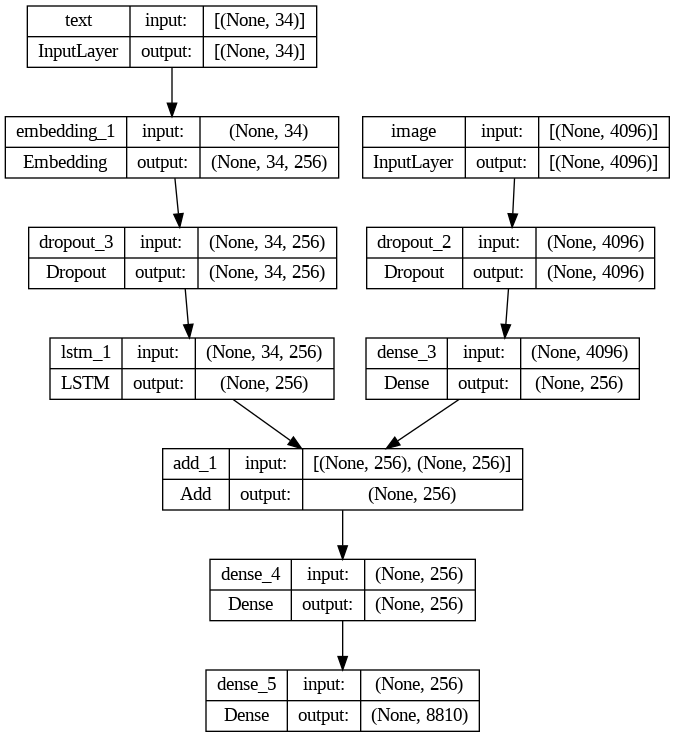

In [48]:
# create data generator to get data in batch (avoids session crash)
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)


In [49]:
#### Pre process for key errors :

error_keys = []

for key in image_features:
    check = 0
    for key2 in image_descriptions:
        if (key == key2):
            check = 1

    if check != 1 :
        print("Key not present in image_description : {}".format(key))
        error_keys.append(key)



for key in image_descriptions:
    check = 0
    for key2 in image_features:
        if (key == key2):
            check = 1

    if check != 1 :
        print("Key not present in image_features : {}".format(key))
        error_keys.append(key)


for i in error_keys:
    if i in image_descriptions :
        del image_descriptions[i]
        print("Key {} has been deleted from image_discriptions".format(key))


    if i in image_features:
        del image_features[i]
        print("Key {} has been deleted from image_features".format(key))



Streaming output truncated to the last 5000 lines.
Key 997722733_0cb5439472 has been deleted from image_discriptions
Key 997722733_0cb5439472 has been deleted from image_discriptions
Key 997722733_0cb5439472 has been deleted from image_discriptions
Key 997722733_0cb5439472 has been deleted from image_discriptions
Key 997722733_0cb5439472 has been deleted from image_discriptions
Key 997722733_0cb5439472 has been deleted from image_discriptions
Key 997722733_0cb5439472 has been deleted from image_discriptions
Key 997722733_0cb5439472 has been deleted from image_discriptions
Key 997722733_0cb5439472 has been deleted from image_discriptions
Key 997722733_0cb5439472 has been deleted from image_discriptions
Key 997722733_0cb5439472 has been deleted from image_discriptions
Key 997722733_0cb5439472 has been deleted from image_discriptions
Key 997722733_0cb5439472 has been deleted from image_discriptions
Key 997722733_0cb5439472 has been deleted from image_discriptions
Key 997722733_0cb5439472 

In [50]:
assert (len(image_features) == len(image_descriptions))

In [51]:
image_ids = list(image_descriptions.keys())
print(image_ids)
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

['1015584366_dfcec3c85a', '1019077836_6fc9b15408', '1022454332_6af2c1449a', '102455176_5f8ead62d5', '1032122270_ea6f0beedb', '1034276567_49bb87c51c', '1042020065_fb3d3ba5ba', '1057210460_09c6f4c6c1', '1072153132_53d2bb1b60', '1100214449_d10861e633', '111766423_4522d36e56', '1160441615_fe6b3c5277', '1215334959_b1970965f7', '1235580648_7eebaed9bc', '124972799_de706b6d0b', '1253275679_e955fb7304', '1287073593_f3d2a62455', '1287931016_fb015e2e10', '1294578091_2ad02fea91', '1302657647_46b36c0d66', '1303548017_47de590273', '1311132744_5ffd03f831', '1322323208_c7ecb742c6', '1330645772_24f831ff8f', '1348891916_ebd4413033', '1394599090_fe0ba238f0', '1394927474_0afdd82fc4', '1397295388_8a5b6b525d', '1402859872_0fc8cf8108', '141755290_4b954529f3', '1425013325_bff69bc9da', '142802798_962a4ec5ce', '1449370354_380c4123c9', '1463638541_c02cfa04dc', '1463732807_0cdf4f22c7', '1473618073_7db56a5237', '1489286545_8df476fa26', '1509786421_f03158adfc', '1536597926_c2e1bc2379', '1540631615_8b42c1b160', '155

In [52]:

# train the model
epochs = 20
batch_size = 32
print(len(train))
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, image_descriptions, image_features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

450
14/14 [==============================] - 4s 312ms/step - loss: 2.5279


In [54]:
model_dir = r"models"
model.save(os.path.join(model_dir,"model_alpha.keras"))


In [55]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = image_descriptions[key]
    # predict the caption for image
    y_pred = predict_caption(model, image_features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))



100%|██████████| 51/51 [02:05<00:00,  2.46s/it]

BLEU-1: 0.071148
BLEU-2: 0.028647



/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [56]:

from PIL import Image
import matplotlib.pyplot as plt
def clean_caption(text):
    end_index = text.lower().find("end")

    if end_index != -1:
        # Extract the part of the text before the first "end"
        cleaned_text = text[:end_index]
    else:
        # If "end" is not found, return the original text
        cleaned_text = text

    return cleaned_text


def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(image_dir, image_name)
    image = Image.open(img_path)
    captions = image_descriptions[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, image_features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    y_pred = clean_caption(y_pred)
    print('--------------------Cleaned--------------------')
    print(y_pred)
    plt.imshow(image)


#### Sample prediction on a random image

---------------------Actual---------------------
<start> man is snowboarding and jumping off of snow hill <end>
<start> person in black jacket is snowboarding during the evening <end>
<start> silhouette of person snowboarding through pile of snow <end>
<start> snowboarder flying off snow drift with colorful sky in the background <end>
<start> the person in the parka is on snowboard <end>
--------------------Predicted--------------------
startseq of parka snowboarding with evening end end end end end end end end end end end end end end end end end end end end end end end end end end end end end
--------------------Cleaned--------------------
startseq of parka snowboarding with evening 


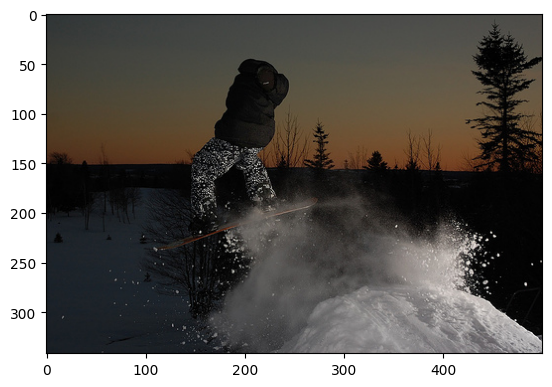

In [57]:
import random

index = random.randint(0, len(image_descriptions))
random_image_id = list(image_descriptions.keys())[index]
generate_caption(random_image_id+".jpg")